## Figure 3: Tissue transcriptomic integration analysis

- Author: Mai T.N. Nguyen
- Email: mai.tn.nguyen@helsinki.fi/ ntnmai303@gmail.com
- Git: https://github.com/maitnnguyen

In [3]:
# library
suppressMessages({
    library(dplyr)
    library(tidyr)
    library(ggplot2)
    library(ggpubr)
    # rna analysis
    library(GSVA)
    library(DESeq2)

})
list_color <- c('#cc3333', '#339933', "#003399")
# MSigDB database
project_dir <- "/mnt/storageBig8/work/nguyenma/projects/ctDNA/ctDNA_release/ctDNArelease_Omics_Integration/"
msigdb <- readRDS(paste0(project_dir, "int/hallmark_pathway.rds"))

# load data
rna_cohort <- read.delim(paste0(project_dir, "data/rna_cohort.tsv"))
weight_factor <- read.delim(paste0(project_dir, "data/rna_weight_factor.tsv"))
exp_raw_mat <- readRDS(paste0(project_dir, "data/rna_raw_matrix_all_samples.RDS"))
exp_norm_mat <- readRDS(paste0(project_dir, "data/rna_norm_matrix_all_samples.RDS"))

# gene symbol
geneInfo <- read.delim(paste0(project_dir, "int/genetype.csv"))


In [11]:
BiocManager::install()
#BiocManager::install('GSVA')

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.16 (BiocManager 1.30.27), R 4.2.1 (2022-06-23)

Installation paths not writeable, unable to update packages
  path: /usr/local/lib/R/site-library
  packages:
    aCGH, affxparser, affy, affyio, ALL, annotate, AnnotationFilter,
    AnnotationForge, AnnotationHub, apeglm, beachmat, BiocSingular,
    BiocVersion, biovizBase, blob, bsseq, bumphunter, Category, CGHbase,
    CGHcall, chipseq, ComplexHeatmap, ConsensusClusterPlus, CopyhelpeR,
    copynumber, CopywriteR, CRImage, crlmm, cummeRbund, cytolib, CytoML,
    DelayedMatrixStats, DESeq2, DEXSeq, DiffBind, DRIMSeq, EBImage, edgeR,
    ensembldb, fastseg, flowClust, flowCore, flowMeans, FlowSOM, flowStats,
    flowViz, flowWorkspace, fpc, gcrma, genefilter, geneplotter, GEOquery,
    ggbio, ggcyto, ggtree, git2r, GO.db, G

### Figure 3a: pathway enrichment heatmap

In [ ]:
# calculate pathway score
## build GSVA parameter object

#gsvapar <- GSVA::gsvaParam(exp_norm_mat, pathways.hallmark, maxDiff=TRUE,
#                            minSize = 20, maxSize = 1000, kcdf = 'Poisson')
#hsi_NES <- GSVA::gsva(gsvapar)

hsi_NES <- GSVA::gsva(as.matrix(exp_norm_mat),
                        msigdb,
                        method="gsva",
                        min.sz=20,
                        max.sz=1000, 
                        kcdf="Poisson")

names(hsi_NES) <- sub('HALLMARK_', '', names(hsi_NES))
hsi_sample <- t(hsi_NES) %>%
    as.data.frame() |>
    tibble::rownames_to_column(var='sample') %>%
    mutate(patient = sub('_.*', '', sample)) |>
    dplyr::select(-sample)

## pathway score by patient level (mean of sample level)
hsi_patient <- hsi_sample %>%
    group_by(patient) %>%
    dplyr::summarise_all(.funs = mean) |>
    left_join(rna_cohort |>
                dplyr::select(patient, TF, ctdna_lev) |>
                distinct()) |>
    dplyr::arrange(TF) |>
    tibble::column_to_rownames(var='patient') |>
    dplyr::select(-TF)

# compare pathway score between ctdna level groups and pickup significant pathways
pathways <- names(hsi_patient)[1:50] |>
    as.data.frame() |>
    dplyr::rename_with(~'pathway') |>
    mutate(Kruskal_Wallis_stat = NA,
           p_val = NA)
  
for (i in pathways$pathway){ 
    dat <- hsi_patient |>
        tibble::rownames_to_column(var='patient') %>%
        dplyr::select(patient, i) %>%
        left_join(rna_cohort %>%
                    dplyr::select(patient, ctdna_lev)|>
                    distinct())

    comp_res <- kruskal.test(dat[,i] ~ dat$ctdna_lev)

    pathways[pathways$pathway==i,2:3] = c(comp_res$statistic[[1]], comp_res$p.value)
}
  
sig.pathways <- pathways[pathways$p_val<.05,]$pathway

# heatmap based on significant pathways
selected_pathways <- hsi_patient[,sig.pathways]

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 12)
ann.row <- selected_pathways |>
      tibble::rownames_to_column(var='patient') |>
      dplyr::select(patient) |>
      left_join(rna_cohort |>
                  dplyr::select(patient, ctdna_tf=TF, ctdna_lev, treatment) |>
                  distinct()) |>
      dplyr::arrange(ctdna_tf) |>
      tibble::column_to_rownames(var='patient') 
    ann.col=list(ctdna_lev = c('low'=list_color[1],
                               'med'=list_color[2], 
                               'high'=list_color[3]),
                 treatment=c('NACT'='#794044','PDS'='#088da5'))
    breaksList = seq(-3, 3, by = .4)

fig3a = pheatmap::pheatmap(selected_pathways, annotation_row = ann.row, 
                       annotation_colors = ann.col, 
                       cluster_rows = F, show_rownames = F, 
                       scale = 'column',
                       color = colorRampPalette(c("#3399ff", "white", "#C40A0A"))(length(breaksList)),
                       breaks = breaksList, gaps_row = c(cumsum(c(51,25,26)),cumsum(c(51,25,26))), border_color = 'black',
                       fontsize_col = 8, cutree_rows = 4, cutree_cols = 2,
                       height = 7, width = 4)
# updating annotation for pathway categories
fig3a[[4]]$grobs[[3]]$gp$col= c('#FC4E07','#E7B800','#E7B800','#E7B800','#E7B800', 
                            '#FC4E07','#FC4E07','#FC4E07','#FC4E07','#FC4E07', 
                            '#00AFBB','#00AFBB','#00AFBB','#00AFBB','#00AFBB',
                            '#00AFBB','#E7B800','#00AFBB','#E7B800','#00AFBB',
                            '#E7B800','#E7B800','#00AFBB','#E7B800','#E7B800')




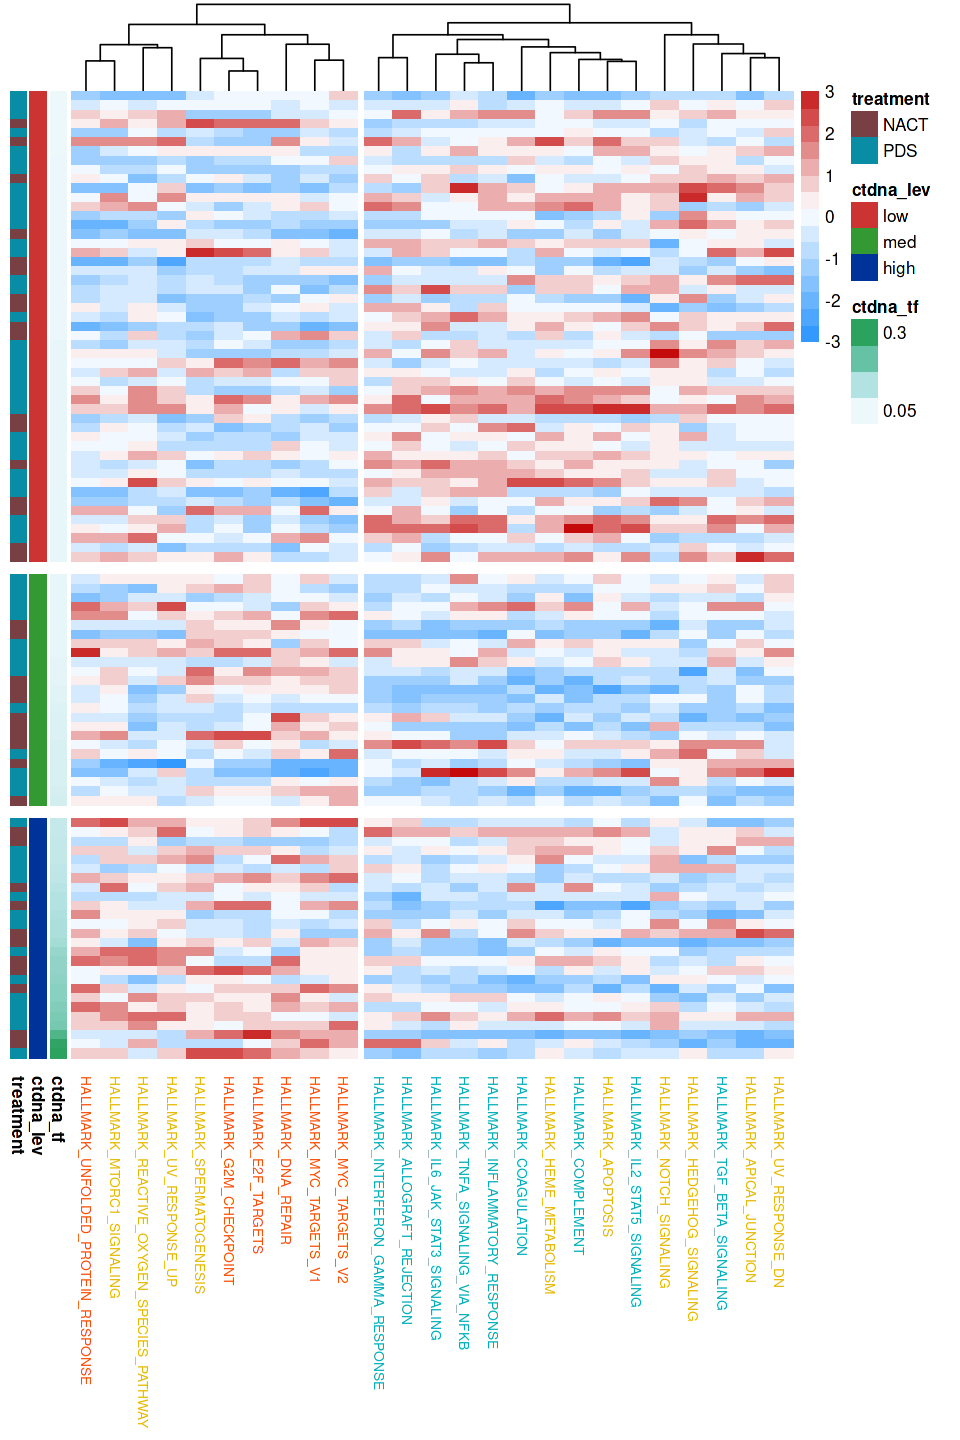

In [6]:
options(repr.plot.width=8, repr.plot.height=12)
# save heatmap
#pdf(paste0(project_dir, "figures/ctDNA_level_pathway_heatmap.pdf"), height = 7, width = 4)
fig3a
#dev.off()

### Figure 3b: PCA plot for factors driving ctDNA fraction variation

In [7]:
res.pca <- prcomp(selected_pathways, scale=F)
#factoextra::fviz_screeplot(res.pca, addlabels = TRUE, ylim = c(0, 70))
# Extract the results for variables
var <- factoextra::get_pca_var(res.pca)
# Contributions of variables to PC1
#factoextra::fviz_contrib(res.pca, choice = "var", axes = 1, top = 10)
# Contributions of variables to PC2
#factoextra::fviz_contrib(res.pca, choice = "var", axes = 2, top = 10)

# contributions of variables to PC1 and PC2
var_contrib <- as.data.frame(factoextra::get_pca_var(res.pca)$contrib)

# For each variable, take the max contribution across PC1 and PC2 (or just PC1)
var_contrib$max_contrib <- apply(var_contrib[, c("Dim.1","Dim.2")], 1, max)

# Set a threshold, e.g., 5% contribution
threshold <- 7
selected_vars <- rownames(var_contrib)[var_contrib$max_contrib >= threshold]

In [8]:
#svg('results/figures_Dec25/main_pca.svg', width = 12, height = 10)
fig3b = factoextra::fviz_pca_biplot(res.pca, geom.ind = "point",axes = c(1, 2),
                            fill.ind=factor(ann.row$ctdna_lev, 
                                            levels = c('low', 'med', 'high')),
                            pointshape=21, pointsize=5, addEllipses = F,
                            col.var="contrib",repel = T, 
                            #geom.var = c("arrow"),
                            select.var = list(name = selected_vars),
                            #col.var.scale = 1,
                            arrowsize = 1.3,
                            labelsize = 5,alpha.ind=.8,
                            gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
                            palette = list_color,
                            title = '') + 
    labs(x = 'PCA1 (38.2%)', y = 'PCA2 (23.5%)') +
    theme_classic()+
    theme(#title = element_blank(),
    axis.title = element_text(size=15, family = 'Arial'), 
    axis.text.y = element_text(size=12, family = 'Arial'),
    axis.text.x = element_text(size=12, family = 'Arial'),
    legend.position = "right", 
    legend.text = element_text(size=15, family = 'Arial'),
    legend.title = element_text(size=20, family = 'Arial'),
    strip.text.x = element_text(size = 15, family = 'Arial'))

fig3b1 = factoextra::fviz_pca_biplot(res.pca, geom.ind = "point",axes = c(1, 3),
                            fill.ind=factor(ann.row$ctdna_lev, 
                                            levels = c('low', 'med', 'high')),
                            pointshape=21, pointsize=5, addEllipses = F,
                            col.var="contrib",repel = T, 
                            #geom.var = c("arrow"),
                            select.var = list(name = selected_vars),
                            #col.var.scale = 1,
                            arrowsize = 1.3,
                            labelsize = 5,alpha.ind=.8,
                            gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
                            palette = list_color,
                            title = '') + 
    labs(x = 'PCA1 (38.2%)', y = 'PCA3 (11.8%)') +
    theme_classic()+
    theme(#title = element_blank(),
    axis.title = element_text(size=15, family = 'Arial'), 
    axis.text.y = element_text(size=12, family = 'Arial'),
    axis.text.x = element_text(size=12, family = 'Arial'),
    legend.position = "right", 
    legend.text = element_text(size=15, family = 'Arial'),
    legend.title = element_text(size=20, family = 'Arial'),
    strip.text.x = element_text(size = 15, family = 'Arial'))
#dev.off()

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”


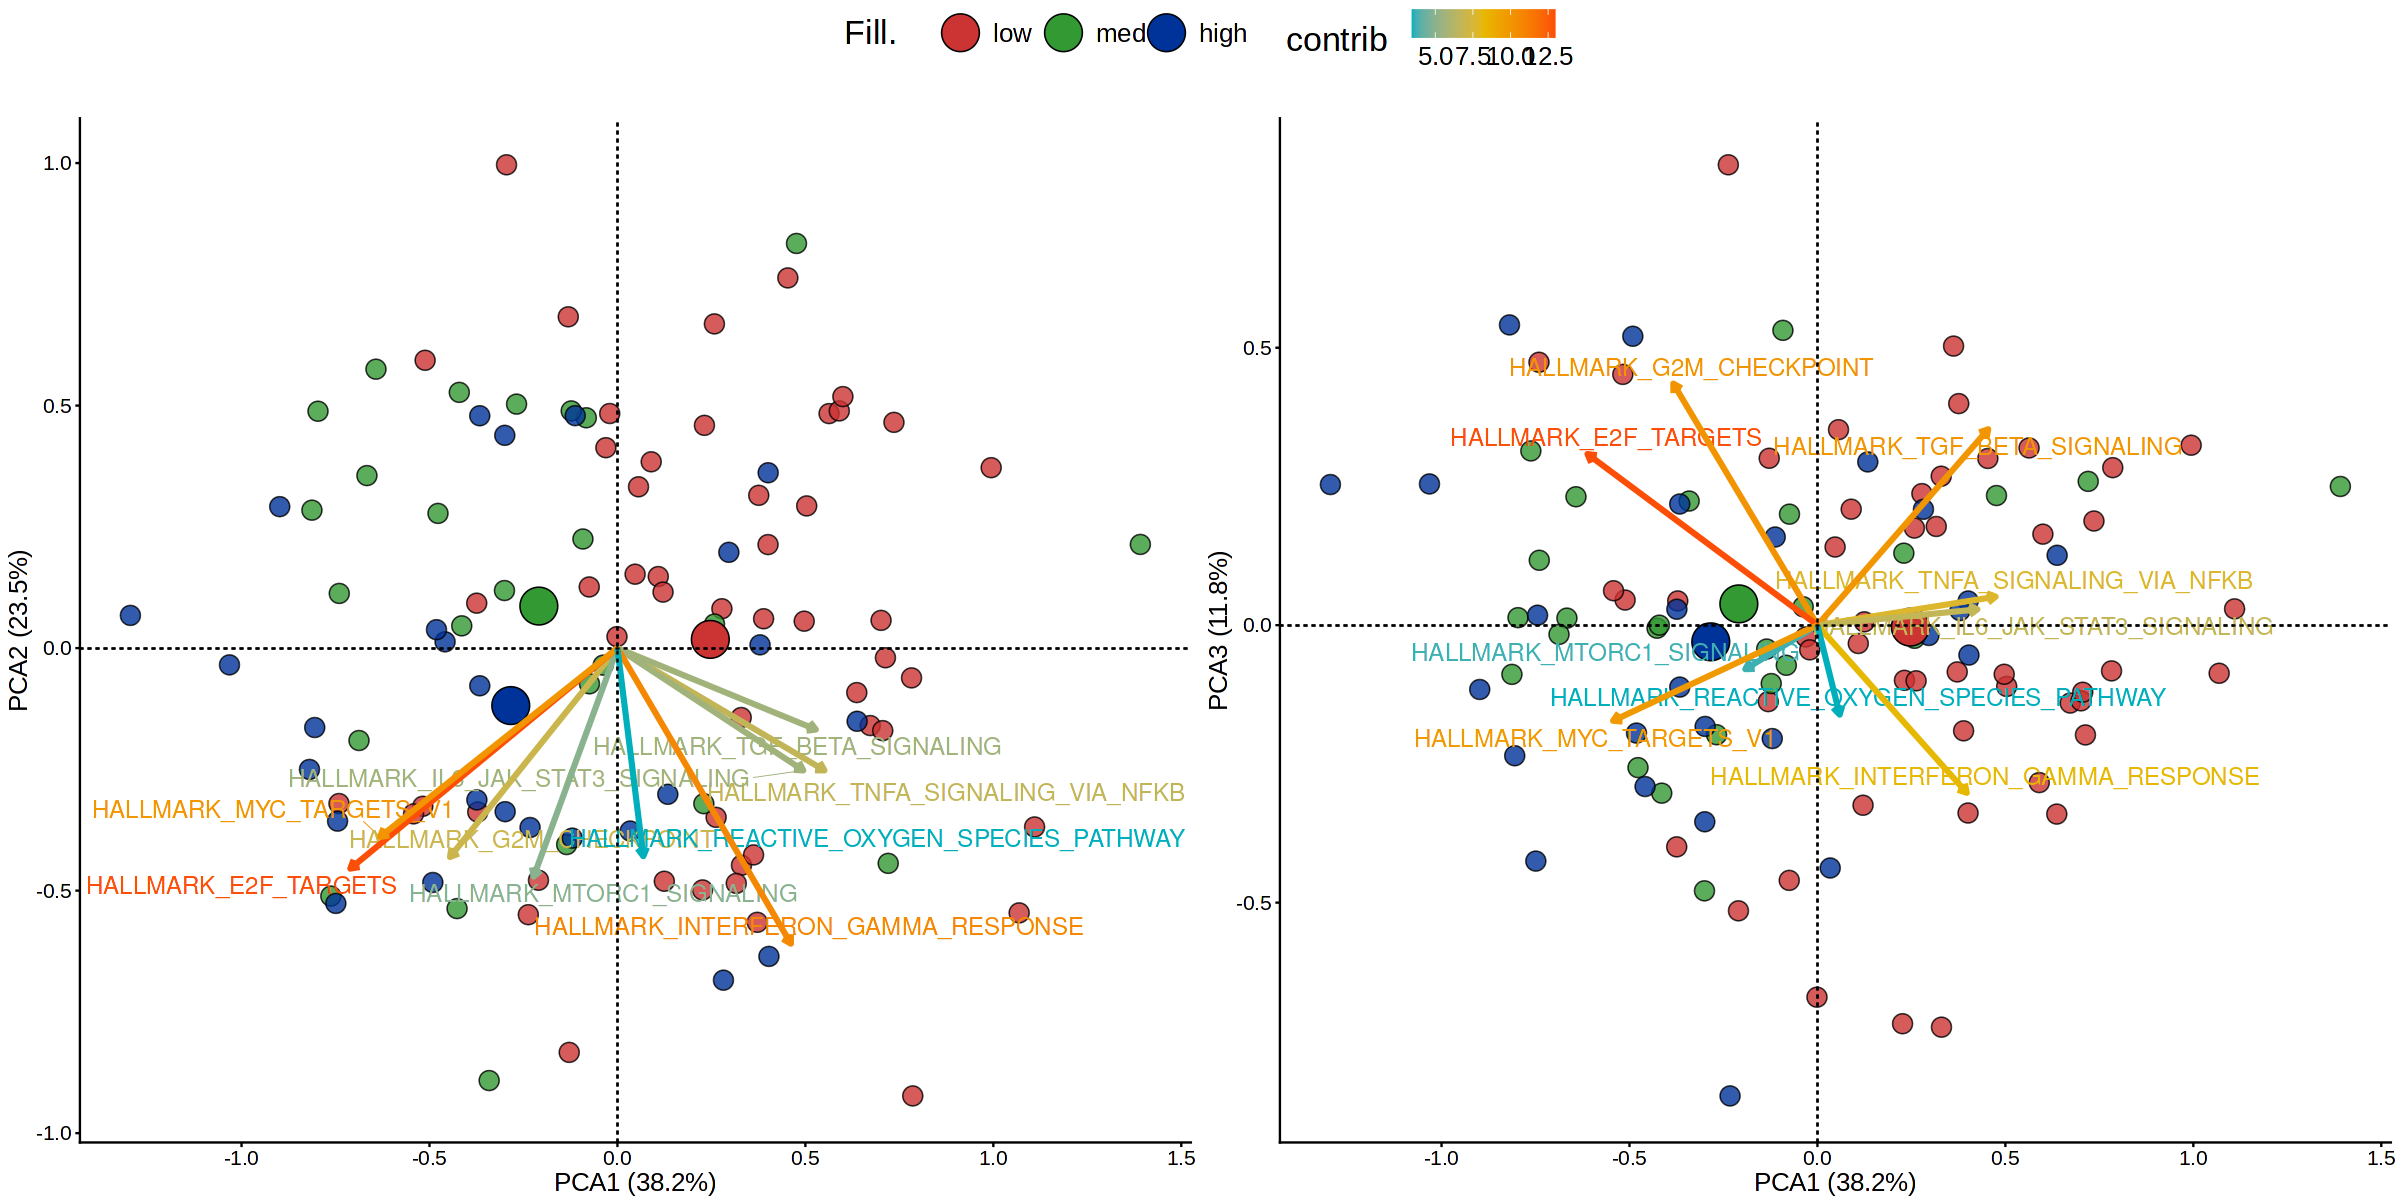

In [ ]:
# visualisation
options(repr.plot.width = 20, repr.plot.height = 10)

suppressWarnings(ggarrange(fig3b , fig3b1, common.legend = T))


### Figure 3c: vocalno plot between low and high ctDNA group

In [10]:
# Running DESeq2 between ctDNA level groups
# select highest purity sample per patient
samples_sel <- rna_cohort |> 
  # filter advanced patients only
  # get one sample per patient only
  dplyr::slice_max(EOC, by = c(patient)) 
  
# check
#nrow(samples_sel) == length(unique(samples_sel$patient))

# running DESeq2
# expression matrix
EOC.Z <- exp_raw_mat[, samples_sel$sample]
#ncol(EOC.Z) == nrow(samples_sel)  
G.EOC <- as.matrix(weight_factor[, samples_sel$sample])
W.EOC <- as.matrix(samples_sel %>% 
                tibble::column_to_rownames(var='sample') |>
                dplyr::select(EOC, Fibroblast, Immune, Unknown))[,'EOC']

col_data <- samples_sel |>
    dplyr::select(sample, tissue_gr, pheno=ctdna_lev, TF, treatment) %>%
    tibble::column_to_rownames(var='sample')

dds <- DESeq2::DESeqDataSetFromMatrix(countData=round(EOC.Z[,rownames(col_data)]), 
                                colData=col_data, 
                                design= ~ 1 + pheno)
# filtering
#table(col_data$pheno)
smallestGroupSize <- 25
keep <- rowSums(DESeq2::counts(dds) > 0) >= smallestGroupSize
dds <- dds[keep,]
dim(dds)
# normalisation factor
normFactors <- (G.EOC * W.EOC )
dds$sizeFactor = unlist(normFactors)
dds$pheno = relevel(dds$pheno, "low")
# run DESeq
dds <- DESeq2::DESeq(dds)
DESeq2::resultsNames(dds)


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 27501   102

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 7475 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"         "pheno_high_vs_low" "pheno_med_vs_low"

In [11]:

# running log fold change shrinking
res_high_low <- DESeq2::lfcShrink(dds, coef='pheno_high_vs_low', 
                                type="apeglm")
res_high_low$SYMBOL = rownames(res_high_low)
res_high_low_Sig <- res_high_low[ which(res_high_low$padj < 0.05 ), ]
dim(res_high_low_Sig)
# save results
#res_high_low_Sig |>
#  as.data.frame() |>
#  write.table('results/files/DGE_highvslow_shrink.tsv', col.names = T, row.names = F, 
#              quote = F, sep = '\t')

# Volcano plot
vol.df.high.low <- res_high_low %>% 
    as.data.frame() %>%
    filter(!is.na(padj)) |>
    arrange(padj) %>%
    left_join(
        geneInfo |> 
        mutate(gene_symbol = ifelse(geneType == 'protein_coding', geneName, NA)) |>
        dplyr::select(SYMBOL=geneName, gene_symbol)
    ) |>
    dplyr::rename(geneName = gene_symbol) %>%
    mutate(thresh=ifelse(log2FoldChange > 1 & padj < .05, 'high ctDNA',
                        ifelse(log2FoldChange > 0 & padj < .05, 'high',
                            ifelse(log2FoldChange < -1 & padj < .05, 'low ctDNA',
                                    ifelse(log2FoldChange < 0 & padj < .05, 'low','')))),
        gene = ifelse((abs(log2FoldChange) > 2 & padj < .01) | 
                        (abs(log2FoldChange) > 1.2 & padj < .05), 
                        geneName, NA))

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 1114    6

Joining with `by = join_by(SYMBOL)`


In [ ]:

fig3c <- vol.df.high.low %>% 
    #filter(log2FoldChange < 5)|>
    mutate(y = -log10(padj)) %>% 
    ggplot(., aes(x = log2FoldChange, y = y, 
                  color=thresh)) + 
    geom_point(size=.2)+
    ggrepel::geom_text_repel(aes(label=gene), size=4, family='Arial') + 
    geom_vline(xintercept = -1, linetype="dotdash", color=list_color[3]) +
    geom_vline(xintercept = 1, linetype="dotdash", color=list_color[3])+
    geom_hline(yintercept = -log10(.05), linetype="dotdash", color=list_color[3])+
    scale_colour_manual(values = c("high ctDNA" = list_color[3], 
                                   "high" = "#b4d3ea",
                                   "low" = "#f4cccc",
                                   "low ctDNA"=list_color[1])) +
    labs(y='Log10 padj', color='Expressed in') + 
    lims(y=c(0,7))+
    theme_classic()+
    theme(title = element_text(size = 13),
          legend.position = 'none',
          panel.grid.major.y = element_blank(),
          panel.grid.minor = element_blank(),
          axis.title = element_text(size=15), 
          axis.text.x = element_text(size=12),
          #legend.position = c(.85,.75),
          legend.text = element_text(size=15),
          legend.title = element_text(size=15),
          strip.text.x = element_text(size = 15))

Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 22691 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“ggrepel: 58 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


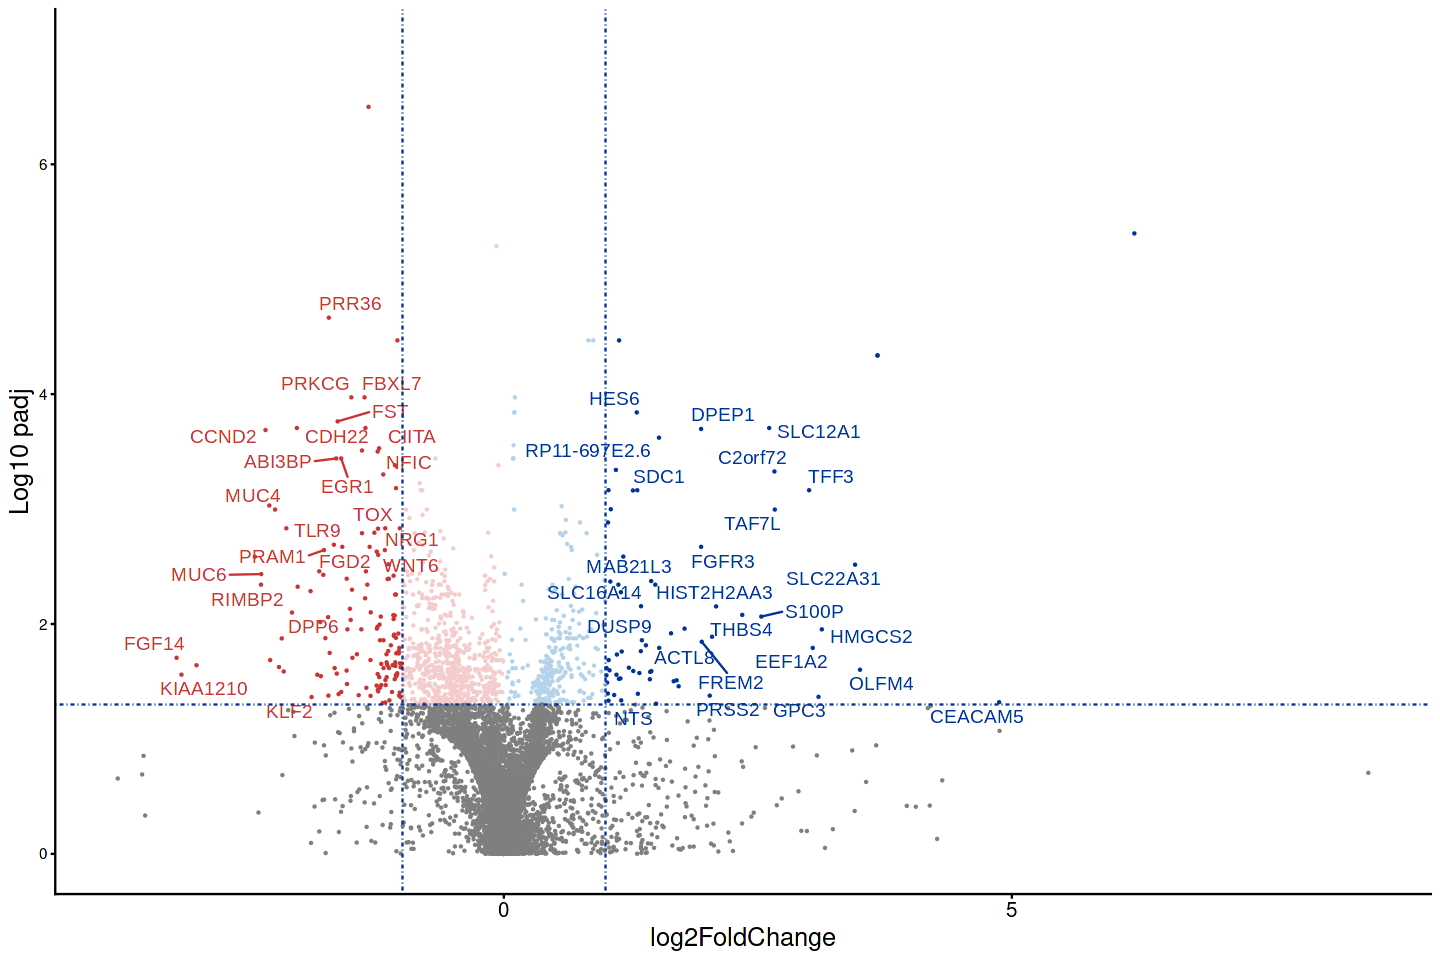

In [17]:
options(repr.plot.width = 12, repr.plot.height = 8)
fig3c

### Figure 3d: Pathway normalized enrichment between low and high ctDNA groups

In [22]:
head(res,2)

log2 fold change (MLE): pheno high vs low 
Wald test p-value: pheno high vs low 
DataFrame with 2 rows and 7 columns
        baseMean log2FoldChange     lfcSE      stat    pvalue      padj
       <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
TSPAN6   3.11731       0.165937  0.188624  0.879724 0.3790088  0.656578
DPM1     1.82812       0.354919  0.147360  2.408512 0.0160177  0.130469
            SYMBOL
       <character>
TSPAN6          NA
DPM1            NA

In [23]:
res <- results(dds, contrast = c('pheno', 'high', 'low'))
res$SYMBOL = rownames(res)
res2 <- as.data.frame(res) %>% #head(2)
filter(!is.na(padj),
        !is.na(SYMBOL),
        !duplicated(SYMBOL)) %>% 
dplyr::arrange(padj) %>% 
dplyr::select(symbol=SYMBOL, stat) 
ranks <- tibble::deframe(res2)

# hallmark database
hallmark.res <- fgsea::fgseaMultilevel(pathways=msigdb, stats=ranks, 
                                        minSize = 20, maxSize = 500)

hallmark.resTidy <- hallmark.res %>%
    as_tibble() %>%
    arrange(desc(NES)) |>
    as.data.frame()

Warning message in prepareStats(stats, scoreType, gseaParam):
“There are ties in the preranked stats (0.03% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [24]:
# plot
fig3d <- hallmark.resTidy %>%
    filter(padj < 0.01) %>% #head(2)
    mutate(pathway=sub('HALLMARK_', '', pathway),
            gr = ifelse(NES > 1, 'high', 'low'),
            logp = -log10(padj)) |>
    ggplot( aes(x=NES,
                y=reorder(pathway, NES))) + #geom_col()
    geom_col(aes(fill= factor(gr, levels=c('high','low'),
                                labels = c('high ctDNA',
                                            'low ctDNA'))),
                width = .5, show.legend = F) +
    scale_fill_manual(values = c(list_color[3], list_color[1])) +
    scale_color_manual(values = c('grey', 'black')) +
    labs(x="Normalised Enrichment Score", 
            y="MSigDB Gene Sets",
            title="") + 
    theme_bw()+
    theme(axis.title = element_text(size=15, family = 'Arial'), 
            axis.text = element_text(size=12, family = 'Arial'),
            #legend.position = 'none',# c(.2,.9),
            legend.text = element_text(size=10, family = 'Arial'),
            legend.title = element_text(size=10, family = 'Arial'),
            strip.text.x = element_text(size = 15, family = 'Arial'))

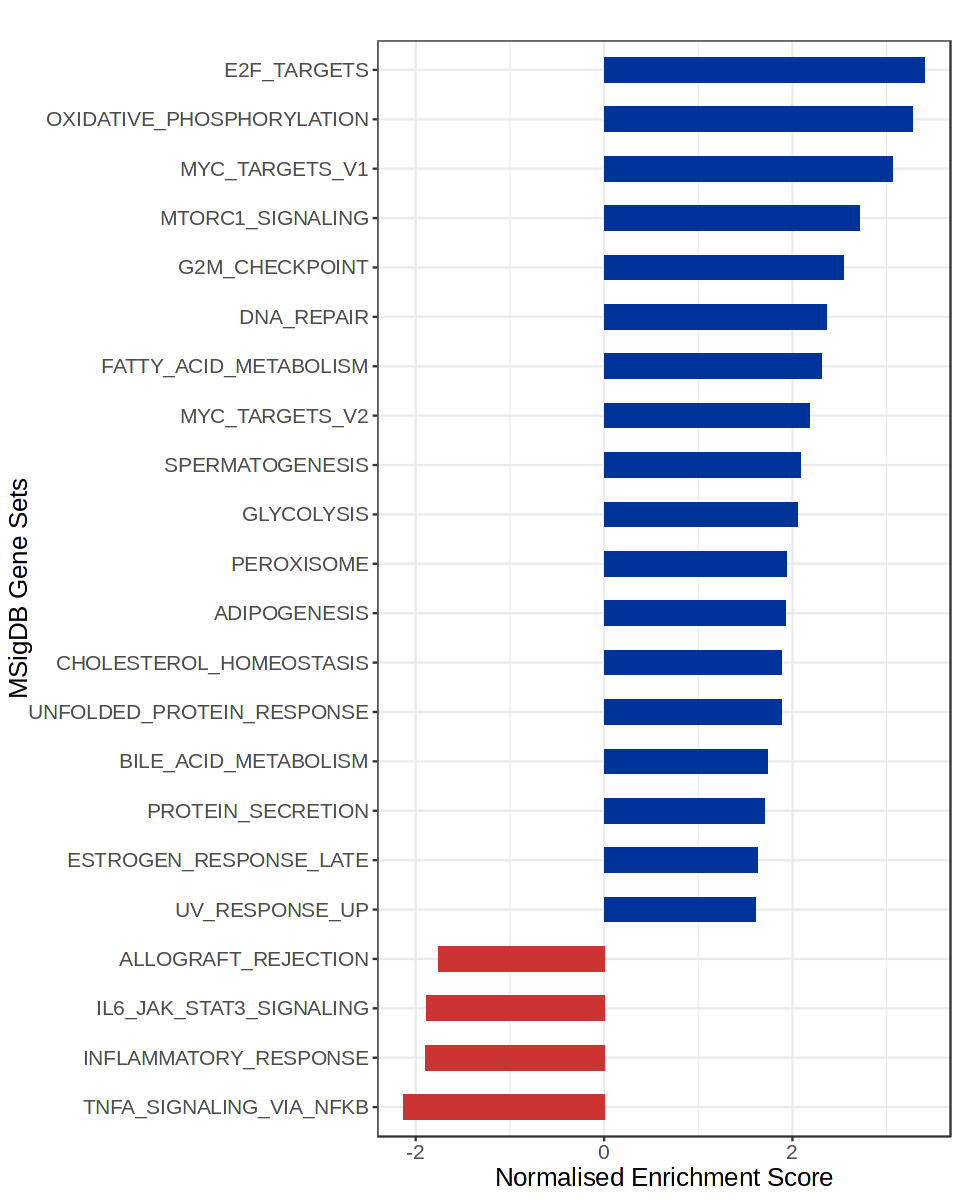

In [26]:
options(repr.plot.width = 8, repr.plot.height = 10)
fig3d

### Figure 3e & 3f: Tumor-associated antigen (TAA) and cancer-testis antigen (CTA) burden between ctDNA groups

In [ ]:
####### estimating tumor-associated antigen load burden (TAB)
# reference: https://github.com/wangxlab/TAA-burden
load(paste0(project_dir,'int/TAA-burden/Data/GTEX_Normal.exp.rda'))
load(paste0(project_dir,'int/TAA-burden/Data/known.CT.antigen.list.rda'))
load(paste0(project_dir,'int/TAA-burden/Data/HEPA.TAA.list.rda'))
source(paste0(project_dir,'int/TAA-burden/R/TAB.modules.Githubv1.R'))

gene_anot = geneInfo |> 
  mutate(id= gsub('\\..*', '',geneID)) |> 
  filter(id %in% rownames(GTEX_Normal.exp))

# normalization expression matrix - highest eoc% sample
tumor.exp <- exp_norm_mat[,samples_sel$sample]
tumor.exp = tumor.exp |>
  as.data.frame() |>
  tibble::rownames_to_column(var='uniqName') |>
  left_join(
    gene_anot |>
      dplyr::select(uniqName,id)
  ) |>
  dplyr::select(-uniqName) |>
  filter(!is.na(id)) |>
  tibble::column_to_rownames(var='id')
tumor.exp = as.matrix(tumor.exp)

# tumor associated antigen burden
TAA.burden = calculate.TAB.combine(
  tumor.expData = tumor.exp, 
  normal.expData = GTEX_Normal.exp, 
  TAA.List = c(HEPA.TAA,known.CT.antigen.list)
)
# cancer testis antigen burden
CTA.burden = calculate.TAB.combine(
  tumor.expData = tumor.exp, 
  normal.expData = GTEX_Normal.exp, 
  TAA.List = known.CT.antigen.list
)

TAA.burden <- TAA.burden |>
  as.data.frame() |>
  tibble::rownames_to_column(var='sample') |>
  left_join(samples_sel)
CTA.burden <- CTA.burden |>
  as.data.frame() |>
  tibble::rownames_to_column(var='sample') |>
  left_join(samples_sel)


Joining with `by = join_by(uniqName)`


In [46]:
#svg('results/figures_Dec25/TAA_burden.svg', width = 3, height = 3.5)
fig3e <- TAA.burden |>
  ggplot(aes(x = factor(ctdna_lev, 
                        levels = c('low', 'med', 'high')),
             y = TAA.burden, 
             fill = factor(ctdna_lev, 
                           levels=c('low', 'med', 'high')))) +
  geom_jitter(
    aes(color = factor(ctdna_lev, 
                       levels = c('low', 'med', 'high'))), alpha=.7,
    position = position_jitterdodge(jitter.width = 1, dodge.width = .4),
    size = 3, show.legend = F
  ) +
  stat_summary(aes(color = ctdna_lev), fun.data="mean_sdl",show.legend = F,
               fun.args = list(mult=1), 
               geom = "pointrange",  size = 1.5,
               position = position_dodge(1))+
  scale_color_manual(values = list_color) +
  stat_compare_means(comparisons = list(c('low', 'med'),
                                        c('high', 'med'),
                                        c('high', 'low')),
                     label = '..p..', size=5,
                     label.y = c(.185,.19,.195), 
                     tip.length = .01) +
  labs(x='', y ='Tumor-associated antigen burden', color='') +
  theme_pubr() +
  theme(panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        axis.title = element_text(size=15), 
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=13),
        legend.position = c(.85,.75),
        legend.text = element_text(size=10),
        legend.title = element_text(size=12),
        strip.text.x = element_text(size = 15)) 
#dev.off()

#svg('results/figures_Dec25/CTA_burden.svg', width = 3, height = 3.5)
fig3f <- CTA.burden |>
  ggplot(aes(x = factor(ctdna_lev, 
                        levels = c('low', 'med', 'high')),
             y = CTA.burden, 
             fill = factor(ctdna_lev, 
                           levels=c('low', 'med', 'high')))) +
  geom_jitter(
    aes(color = factor(ctdna_lev, 
                       levels = c('low', 'med', 'high'))), alpha=.7,
    position = position_jitterdodge(jitter.width = 1, dodge.width = .4),
    size = 3, show.legend = F
  ) +
  stat_summary(aes(color = ctdna_lev), fun.data="mean_sdl",show.legend = F,
               fun.args = list(mult=1), 
               geom = "pointrange",  size = 1.5,
               position = position_dodge(1))+
  scale_color_manual(values = list_color) +
  stat_compare_means(comparisons = list(c('low', 'med'),
                                        c('high', 'med'),
                                        c('high', 'low')),
                     label = '..p..', size=5,
                     label.y = c(.225,.235,.245), 
                     tip.length = .01) +
  labs(x='', y ='Cancer-testis antigen burden', color='') +
  theme_pubr() +
  theme(panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        axis.title = element_text(size=15), 
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=13),
        legend.position = c(.85,.75),
        legend.text = element_text(size=10),
        legend.title = element_text(size=12),
        strip.text.x = element_text(size = 15)) 
#dev.off()

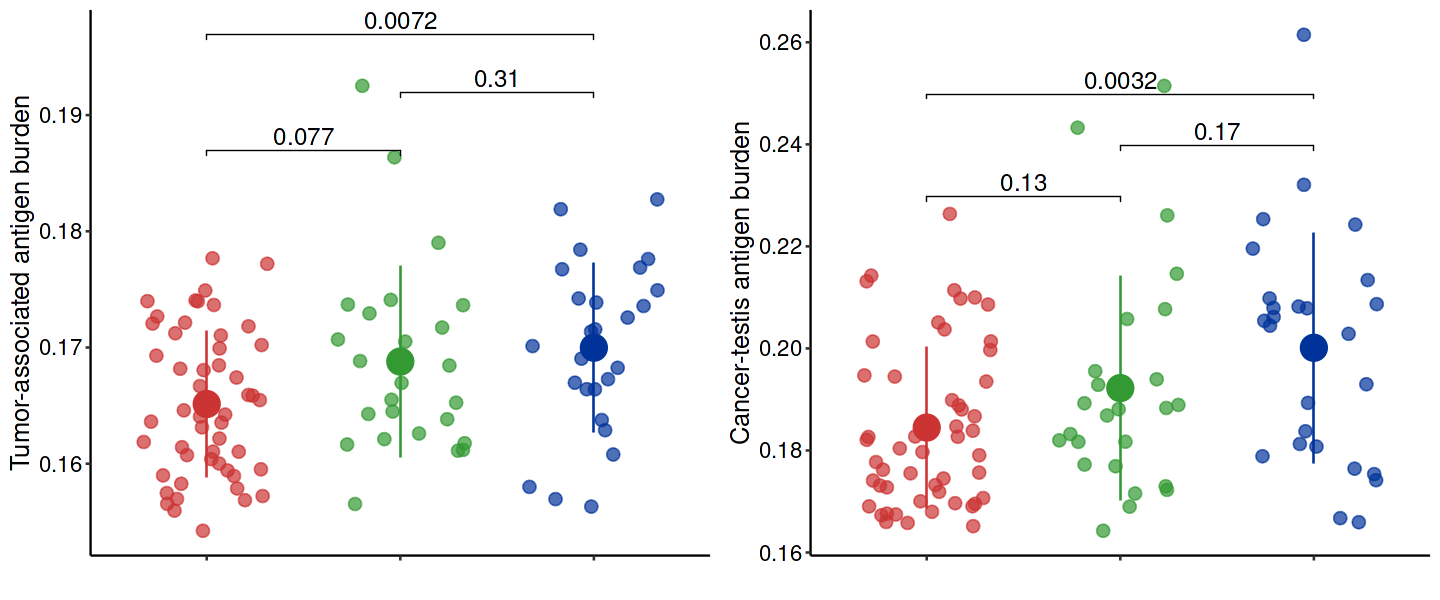

In [53]:
options(repr.plot.width = 12, repr.plot.height = 5)
ggarrange(fig3e, fig3f, common.legend = TRUE)